In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from vae_anomaly_detection import (
    load_and_prepare_data,
    CrimeDataset,
    VAE,
    train_vae,
    get_reconstruction_errors,
    detect_anomalies,
    per_feature_errors
)

plt.rcParams.update({"figure.dpi": 140})
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


In [2]:
DATA_PATH = "lapd_offenses_victims_features.pkl"

train_df, test_df, encoders, feature_names = load_and_prepare_data(
    DATA_PATH,
    test_size=0.20
)

In [3]:
# -------- DATALOADERS --------
train_loader = DataLoader(CrimeDataset(train_df), batch_size=128, shuffle=True)
test_loader  = DataLoader(CrimeDataset(test_df),  batch_size=128, shuffle=False)

In [4]:
model = VAE(input_dim=train_df.shape[1], hidden_dims=[256,128,64], latent_dim=8)

In [5]:
losses = train_vae(
    model,
    train_loader,   
    epochs=70,
    lr=1e-3,
    beta=1.0,
    device=DEVICE
)

Epoch 0/70 - Avg loss: 1.708271
Epoch 10/70 - Avg loss: 1.686871
Epoch 20/70 - Avg loss: 1.686739
Epoch 30/70 - Avg loss: 1.686683
Epoch 40/70 - Avg loss: 1.686630
Epoch 50/70 - Avg loss: 1.686619
Epoch 60/70 - Avg loss: 1.686611


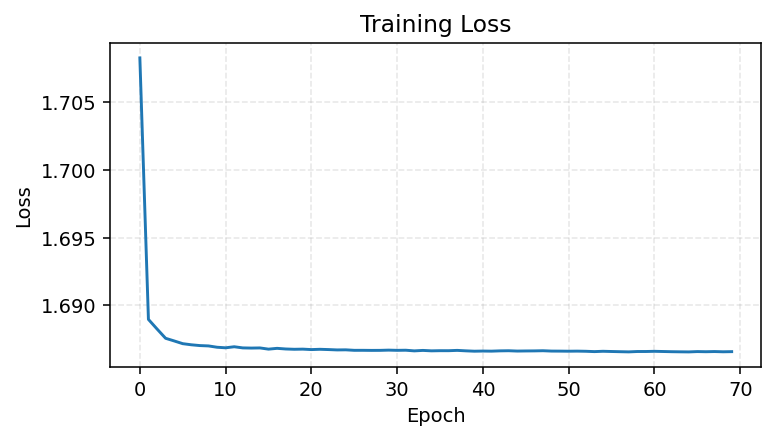

In [15]:
plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

In [7]:
train_err, train_z = get_reconstruction_errors(model, train_loader, device=DEVICE)
test_err,  test_z  = get_reconstruction_errors(model, test_loader,  device=DEVICE)

In [8]:
test_is_anom, recon_thresh = detect_anomalies(
    test_err,
    test_z,
    recon_percentile=97.5,
    min_distance=0.05
)

print("Anomalies detected:", test_is_anom.sum())

Anomalies detected: 0


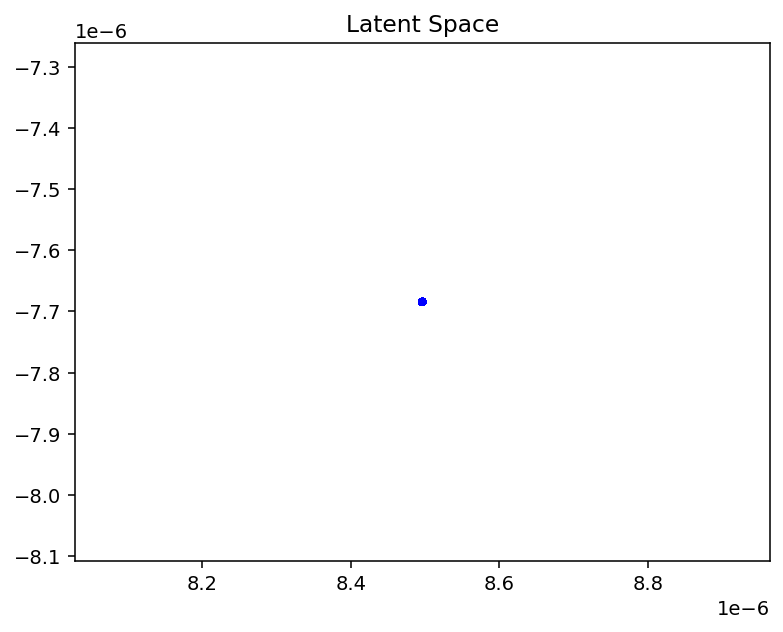

In [ ]:
plt.figure(figsize=(6, 3))
plt.scatter(test_z[:,0], test_z[:,1],
            c=["red" if a else "blue" for a in test_is_anom],
            alpha=0.6, s=10)
plt.title("Latent Space")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

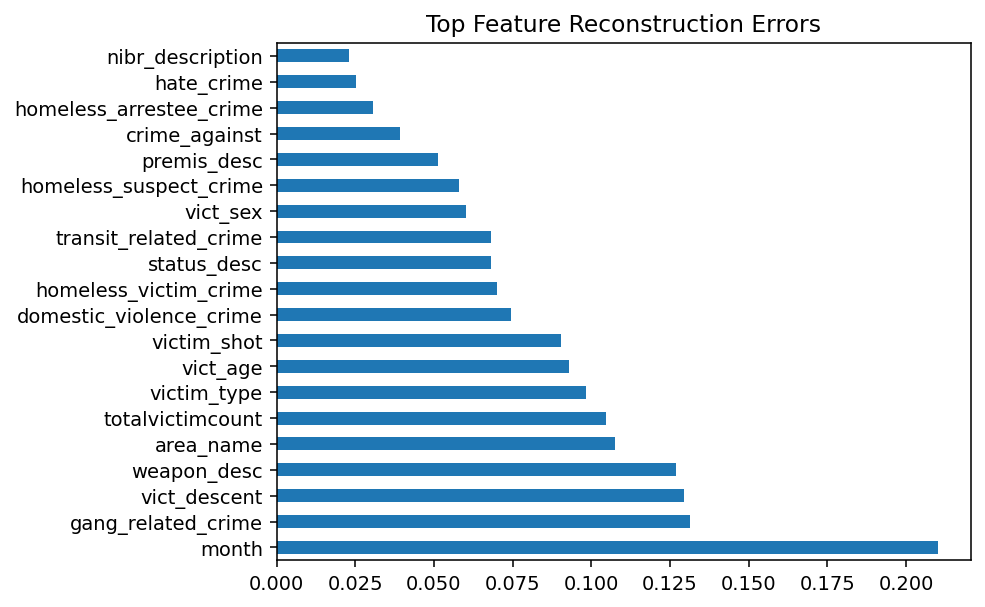

In [ ]:
err_df, orig_df, recon_df = per_feature_errors(model, test_loader, feature_names)

top_feats = err_df.mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(6, 3))
top_feats.plot.barh()
plt.title("Top Feature Reconstruction Errors")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

In [11]:
anom_ids = np.where(test_is_anom)[0]

for idx in anom_ids[:3]:
    print("\n====== Test Anomaly:", idx, "======")
    row = pd.DataFrame({
        "feature": feature_names,
        "original": orig_df.iloc[idx],
        "reconstructed": recon_df.iloc[idx],
        "squared_error": err_df.iloc[idx]
    })
    display(row.sort_values("squared_error", ascending=False).head(10))

In [12]:
torch.save({
    "model_state": model.state_dict(),
    "encoders": encoders,
    "feature_names": feature_names
}, "vae_crime_labelencoded_model.pth")
print("Saved model.")

Saved model.
